# Figures

## Plot of experimental, experimental data model ensemble prediction (mean & variance) and ideal responses

2023-12-02 22:10:14.585617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-12-02 22:10:14.590621: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:10:14.590801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:10:14.591640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 22:10:14.592266: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

1/1 [==============================] - 0s 401ms/step


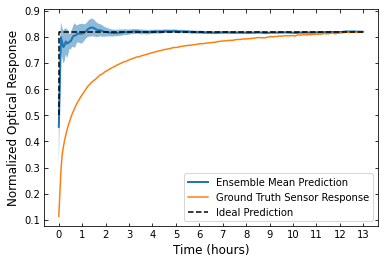

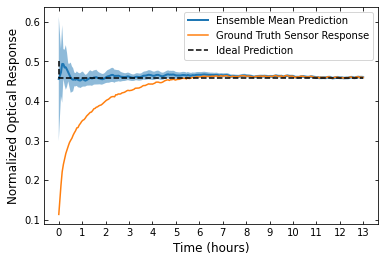

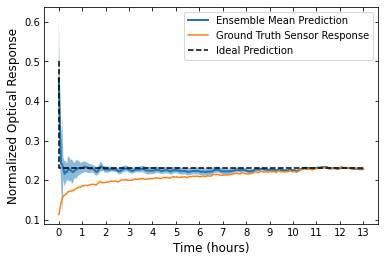

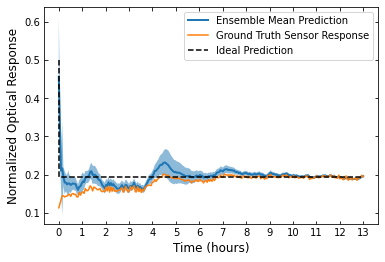

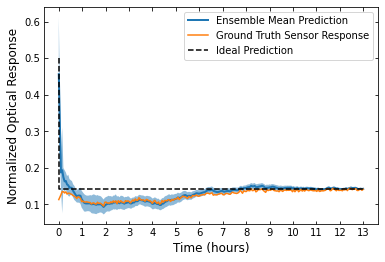

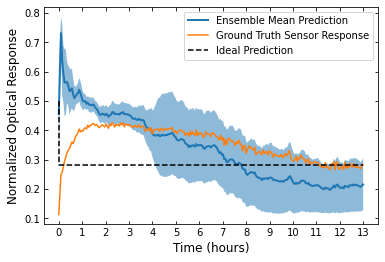

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

# 
NumEnsemble = 15
SequenceLength = 250
batch_size = 4
experiment_num = [11,46,57,39,47,59]#16,42
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

# slicing 
X_test = df_norm_test.iloc[:,:SequenceLength].values
y_test = df_norm_test.iloc[:,SequenceLength-1].values
X_test = np.expand_dims(X_test, 2)
y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
y_test = np.expand_dims(y_test, 2)


Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X_test[experiment_num,::], 2)

# idealTime = np.append([0,0], time.iloc[2:,].values)
# idealPrediction = np.ones(len(idealTime))*X_predict[0,-1,0]
# idealPrediction[0] = 0.5

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X_test, y_test, batch_size=batch_size,verbose=0)
    if(loss<-2):
        prediction = bestModel.predict(X_predict)
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

Mean = np.squeeze(Mean)
Stdev = np.squeeze(Variance**0.5)
idealTime = np.append([0,0], time.iloc[2:,].values)
time = np.array(time, dtype=float)

for mean,x,stdev,num in zip(Mean,X_predict,Stdev,experiment_num):
    
    idealPrediction = np.ones(len(idealTime))*x[-1,0,0]
    idealPrediction[0] = 0.5

    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+stdev*StdevsFromMean), (mean-stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
    
    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)
    
    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()#loc='upper right')
    plt.savefig(f"../Figures/ExperimentalEnsemblePredictionIdealResponses{num}.tif", dpi=200, bbox_inches='tight')
    plt.show()

## Panel plot of experimental, experimental data model ensemble prediction (mean & variance) and ideal responses

2023-12-02 22:14:53.897617: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:14:53.902535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:14:53.902710: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:14:53.903915: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2023-12-02 22:14:57.329949: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-12-02 22:14:57.863667: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 399ms/step


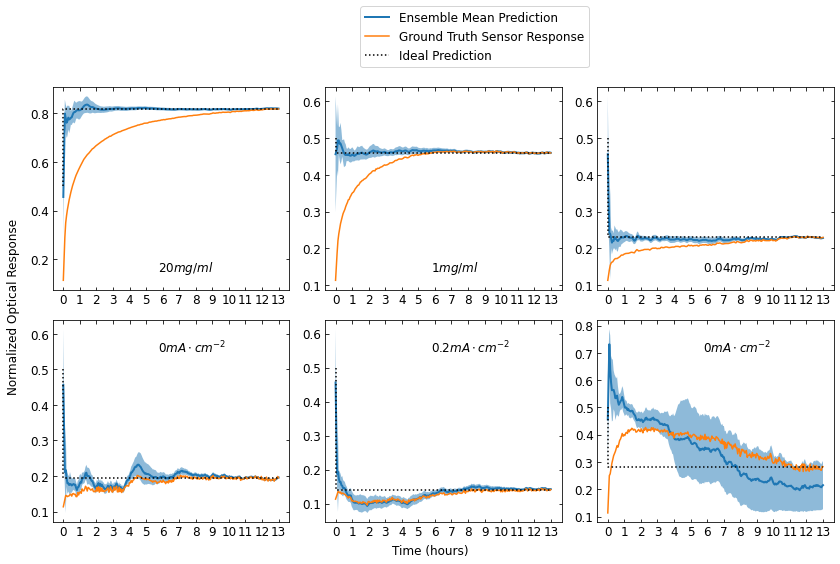

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

# 
NumEnsemble = 15
SequenceLength = 250
batch_size = 4
experiment_num = [11,39,46,47,57,59]
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

# slicing 
X_test = df_norm_test.iloc[:,:SequenceLength].values
y_test = df_norm_test.iloc[:,SequenceLength-1].values
X_test = np.expand_dims(X_test, 2)
y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
y_test = np.expand_dims(y_test, 2)

Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X_test[experiment_num,::], 2)

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X_test, y_test, batch_size=batch_size,verbose=0)
    if(loss<-2):
        prediction = bestModel.predict(X_predict)
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

Mean = np.squeeze(Mean)
Stdev = np.squeeze(Variance**0.5)
idealTime = np.append([0,0], time.iloc[2:,].values)
time = np.array(time, dtype=float)

fig, ax = plt.subplots(2, 3)

ii = [0,1,0,1,0,1]
jj = [0,0,1,1,2,2]

for mean,x,stdev,num,i,j in zip(Mean,X_predict,Stdev,experiment_num,ii,jj):
    
    idealPrediction = np.ones(len(idealTime))*x[-1,0,0]
    idealPrediction[0] = 0.5

    ax[i,j].fill_between(time, (mean+stdev*StdevsFromMean), (mean-stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax[i,j].plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    ax[i,j].plot(time,tf.squeeze(x), label="Ground Truth Sensor Response")
    ax[i,j].plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle=':',linewidth=1.5)
    
    ax[i,j].tick_params(right=True, top=True, labelleft=True, labelright=False, labelbottom=True, labeltop=False, labelsize=12)
    ax[i,j].tick_params(direction="in")
    ax[i,j].set_xticks(range(14))
    ax[i,j].tick_params(axis="both", which="both", direction="in")


fig.text(0.5, 0.07, 'Time (hours)', ha='center', fontsize=12)
fig.text(0.08, 0.5, 'Normalized Optical Response', va='center', rotation='vertical', fontsize=12)

fig.text(0.23, 0.56, '20'+ r'$mg / ml$',fontsize=12)
fig.text(0.5, 0.56, '1'+ r'$mg / ml$',fontsize=12)
fig.text(0.77, 0.56, '0.04'+ r'$mg / ml$',fontsize=12)
fig.text(0.23, 0.42, '0'+ r'$mA \cdot cm^{-2}$',fontsize=12)
fig.text(0.5, 0.42, '0.2'+ r'$mA \cdot cm^{-2}$',fontsize=12)
fig.text(0.77, 0.42, '0'+ r'$mA \cdot cm^{-2}$',fontsize=12)

ax[0,0].legend(loc=[1.3,1.1],fontsize=12)

plt.tick_params(right = False)
plt.subplots_adjust(wspace=0.15, hspace=0.15)
fig.set_figwidth(14)
fig.set_figheight(8)

    
plt.savefig(f"../Figures/PanelExperimentalEnsemblePredictionIdealResponses.tif", dpi=200, bbox_inches='tight')
plt.show()

## Histogram of experimental and experimental data model predicted t90 times

2023-12-02 22:17:20.221616: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:17:20.226576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:17:20.226764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:17:20.227792: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2023-12-02 22:17:23.622070: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 5/20 [======>.......................] - ETA: 0s - loss: -3.7862

2023-12-02 22:17:24.176652: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 1s 33ms/step

prediction t90 summary statistics
               0
count  78.000000
mean    2.304882
std     3.286466
min     0.051990
25%     0.155969
50%     0.779847
75%     3.613293
max    12.997456

experimental t90 summary statistics
               0
count  78.000000
mean    3.954559
std     2.618614
min     0.363929
25%     2.391532
50%     3.665282
75%     4.614097
max    12.945466

ratio of experimental to predicted t90 summary statistics
                0
count   78.000000
mean    18.619599
std     26.613287
min      0.135135
25%      1.007753
50%      5.070833
75%     26.250000
max    106.000000


/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


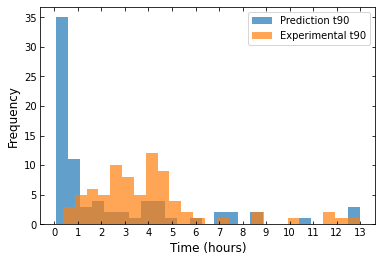

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 15

# length of time series
SequenceLength = 250

batch_size = 4
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

# t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
t90Window = 0.1

NumberOfBins = 25

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    
    ## make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []
MeanNormVariance = []

for mean,x,variance in zip(Mean,X,Variance):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    NormVariance = variance
    
    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    MeanNormVariance.append(np.mean(NormVariance))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]
MeanNormVariance = np.array(MeanNormVariance)

print('\nprediction t90 summary statistics')
print(pd.DataFrame(PredictionT90).describe())
print('\nexperimental t90 summary statistics')
print(pd.DataFrame(ExperimentalT90).describe())
print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

freq, bins = np.histogram(PredictionT90, NumberOfBins)

BinNormVarianceMean = []
BinNormVarianceStdev = []
for i in range(NumberOfBins):
    indices = np.where((PredictionT90 >= bins[i]) & (PredictionT90 < bins[i+1]))
    BinNormVarianceMean.append(np.mean(MeanNormVariance[indices]))
    BinNormVarianceStdev.append(np.std(MeanNormVariance[indices]))

fig, ax = plt.subplots()
ax.hist(PredictionT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Prediction t90')
ax.hist(ExperimentalT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Experimental t90')

ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Time (hours)', fontsize = 12)

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(14))
ax.legend(loc='upper right')

plt.savefig(".."+"/Figures/PredictedExperimentalt90Histogram.tif", dpi=200, bbox_inches='tight')
plt.show()

## Histogram of experimental and experimental data model predicted t90 times with variance subplot indicating S/N

2023-12-02 22:25:21.221618: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:25:21.226451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:25:21.226626: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


2023-12-02 22:25:21.227559: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-02 22:25:21.228298: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:25:21.228482: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:25:21.228644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

 5/20 [======>.......................] - ETA: 0s - loss: -3.7862

2023-12-02 22:25:25.173625: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 0s 32ms/step

prediction t90 summary statistics
               0
count  78.000000
mean    2.304882
std     3.286466
min     0.051990
25%     0.155969
50%     0.779847
75%     3.613293
max    12.997456

experimental t90 summary statistics
               0
count  78.000000
mean    3.954559
std     2.618614
min     0.363929
25%     2.391532
50%     3.665282
75%     4.614097
max    12.945466

ratio of experimental to predicted t90 summary statistics
                0
count   78.000000
mean    18.619599
std     26.613287
min      0.135135
25%      1.007753
50%      5.070833
75%     26.250000
max    106.000000


/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/simonjward/anaconda3/envs/tf/lib/python3.9/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


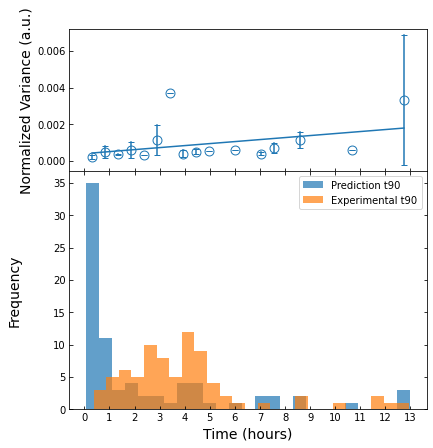

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import pylab
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 15
# length of time series
SequenceLength = 250
batch_size = 4
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
validation_split = 0.25
NumberOfBins = 25
viridisColour1 = 30
viridisColour2 = 120
markerSize = 80

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

train_labels = df_train.iloc[:,0]

df_train, df_val = train_test_split(df_train, test_size=validation_split, train_size=1-validation_split, random_state=42, shuffle=True, stratify=train_labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)
df_norm_val = (df_val - min_value)/(max_value - min_value)

X_val = df_norm_val.iloc[:,:SequenceLength].values
y_val = df_norm_val.iloc[:,SequenceLength-1].values
X_val = np.expand_dims(X_val, 2)
y_val = np.broadcast_to(y_val[:,None], (y_val.shape[0],SequenceLength))
y_val = np.expand_dims(y_val, 2)

MeanImprovementEnsembleSizes = []
MedianImprovementEnsembleSizes = []

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
    Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2
    
Mean /= NumEnsemble
Variance /= NumEnsemble
Variance -= Mean**2

PredictionT90 = []
ExperimentalT90 = []
MeanNormVariance = []

for mean,x,variance in zip(Mean,X,Variance):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
    NormVariance = variance/x[-1]
    
    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    MeanNormVariance.append(np.mean(NormVariance))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]
MeanNormVariance = np.array(MeanNormVariance)

print('\nprediction t90 summary statistics')
print(pd.DataFrame(PredictionT90).describe())
print('\nexperimental t90 summary statistics')
print(pd.DataFrame(ExperimentalT90).describe())
print('\nratio of experimental to predicted t90 summary statistics')
print(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).describe())

freq, bins = np.histogram(PredictionT90, NumberOfBins)
BinNormVarianceMean = []
BinNormVarianceStdev = []
for i in range(NumberOfBins):
    indices = np.where((PredictionT90 >= bins[i]) & (PredictionT90 <= bins[i+1]))
    BinNormVarianceMean.append(np.mean(MeanNormVariance[indices]))
    BinNormVarianceStdev.append(np.std(MeanNormVariance[indices]))

BinCenters = np.array([(bins[i+1]+bins[i])/2 for i in range(NumberOfBins)])
BinNormVarianceMean = np.array(BinNormVarianceMean)
BinNormVarianceStdev = np.array(BinNormVarianceStdev)

LinearFit = LinearRegression()
BinCentersDropNa = BinCenters[~np.isnan(BinNormVarianceMean)]
BinNormVarianceMeanDropNa = BinNormVarianceMean[~np.isnan(BinNormVarianceMean)]
BinNormVarianceStdevDropNa = BinNormVarianceStdev[~np.isnan(BinNormVarianceMean)]
LinearFit.fit(np.reshape(BinCentersDropNa,(-1, 1)), np.reshape(BinNormVarianceMeanDropNa,(-1, 1)))

fig, (ax1, ax2) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': [1.8, 3]},figsize=[6.4, 7])

ax1.scatter(BinCentersDropNa,BinNormVarianceMeanDropNa, facecolor=(0,0,0,0), marker='o', s=markerSize, edgecolor='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.plot([BinCentersDropNa, BinCentersDropNa], [BinNormVarianceMeanDropNa+BinNormVarianceStdevDropNa, BinNormVarianceMeanDropNa-BinNormVarianceStdevDropNa], marker="_", color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.plot(BinCentersDropNa,LinearFit.predict(np.reshape(BinCentersDropNa,(-1, 1))),color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax1.set_ylabel('Normalized Variance (a.u.)', fontsize = 14)
ax1.tick_params(direction="in")

ax2.hist(PredictionT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Prediction t90',color='tab:blue')#pylab.cm.viridis(viridisColour1))
ax2.hist(ExperimentalT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Experimental t90',color='tab:orange')#pylab.cm.viridis(viridisColour2))

ax2.set_ylabel('Frequency', fontsize = 14, labelpad=32)
ax2.set_xlabel('Time (hours)', fontsize = 14)

ax2.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax2.tick_params(direction="in")
ax2.set_xticks(range(14))
ax2.legend(loc='upper right')

fig.subplots_adjust(hspace=0)

plt.savefig(".."+"/Figures/PredictedExperimentalt90HistogramNormVariance.tif", dpi=200, bbox_inches='tight')
plt.show()

## Plot of Mean and Median t90 Response Time Reduction for Ensembles containing 1 to 30 Base Learners

2023-12-02 22:32:37.049615: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:32:37.054526: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:32:37.054713: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 22:32:37.055177: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

 5/20 [======>.......................] - ETA: 0s - loss: -4.0515

2023-12-02 22:32:41.014166: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


20/20 [==============================] - 1s 34ms/step - loss: -3.9071


Number of Base Learners = 1


3/3 [==============================] - 1s 28ms/step


Number of Base Learners = 2


3/3 [==============================] - 0s 29ms/step


Number of Base Learners = 3


3/3 [==============================] - 0s 26ms/step


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 4


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 5


3/3 [==============================] - 0s 31ms/step


Number of Base Learners = 6


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 7


3/3 [==============================] - 0s 36ms/step


Number of Base Learners = 8




3/3 [==============================] - 0s 28ms/step


Number of Base Learners = 9


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 10


3/3 [==============================] - 0s 36ms/step


Number of Base Learners = 11


3/3 [==============================] - 0s 32ms/step


3/3 [==============================] - 0s 29ms/step


Number of Base Learners = 12


3/3 [==============================] - 0s 27ms/step


Number of Base Learners = 13


3/3 [==============================] - 0s 28ms/step


3/3 [==============================] - 0s 28ms/step


Number of Base Learners = 14


3/3 [==============================] - 0s 28ms/step


Number of Base Learners = 15


3/3 [==============================] - 0s 36ms/step


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 16


3/3 [==============================] - 0s 23ms/step


Number of Base Learners = 17


3/3 [==============================] - 0s 28ms/step


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 18


3/3 [==============================] - 0s 28ms/step


Number of Base Learners = 19


3/3 [==============================] - 0s 31ms/step


3/3 [==============================] - 0s 23ms/step


Number of Base Learners = 20


3/3 [==============================] - 0s 23ms/step


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 21


3/3 [==============================] - 0s 32ms/step


3/3 [==============================] - 0s 30ms/step


Number of Base Learners = 22


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 23


3/3 [==============================] - 0s 32ms/step


3/3 [==============================] - 0s 33ms/step


Number of Base Learners = 24


3/3 [==============================] - 0s 24ms/step


3/3 [==============================] - 0s 36ms/step


Number of Base Learners = 25


3/3 [==============================] - 0s 32ms/step


3/3 [==============================] - 0s 35ms/step


Number of Base Learners = 26


3/3 [==============================] - 0s 28ms/step


3/3 [==============================] - 0s 39ms/step


Number of Base Learners = 27


3/3 [==============================] - 0s 32ms/step


3/3 [==============================] - 0s 29ms/step


Number of Base Learners = 28


3/3 [==============================] - 0s 24ms/step


3/3 [==============================] - 0s 32ms/step


Number of Base Learners = 29


3/3 [==============================] - 0s 28ms/step


3/3 [==============================] - 0s 27ms/step


Number of Base Learners = 30


3/3 [==============================] - 0s 28ms/step


3/3 [==============================] - 0s 32ms/step
[0    15.387522
dtype: float64, 0    18.569512
dtype: float64, 0    21.054195
dtype: float64, 0    20.208885
dtype: float64, 0    21.538963
dtype: float64, 0    20.570877
dtype: float64, 0    19.971838
dtype: float64, 0    20.891609
dtype: float64, 0    21.136272
dtype: float64, 0    21.816474
dtype: float64, 0    22.213673
dtype: float64, 0    22.832909
dtype: float64, 0    22.717652
dtype: float64, 0    22.963365
dtype: float64, 0    22.414347
dtype: float64, 0    22.510796
dtype: float64, 0    22.855857
dtype: float64, 0    22.390253
dtype: float64, 0    22.594419
dtype: float64, 0    22.777291
dtype: float64, 0    22.784535
dtype: float64, 0    22.939486
dtype: float64, 0    22.828367
dtype: float64, 0    22.828954
dtype: float64, 0    22.816754
dtype: float64, 0    22.811857
dtype: float64, 0    22.81363
dtype: float64, 0    22.80648
dtype: float64, 0    22.558499
dtype: float64, 0    22.555185
dtype: float64]
[0    4.277473
dtyp

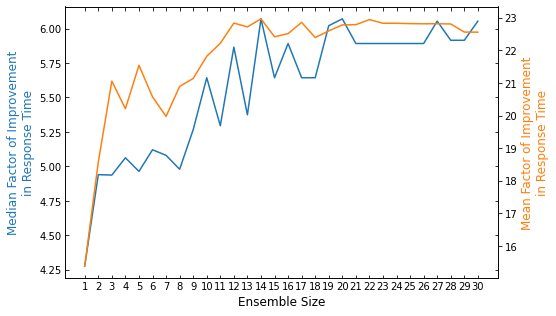

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
import pylab
from random import randrange

## input parameters

# number of models in the ensemble
TrainedBaseLearners = 30
validation_split = 0.25
# length of time series
SequenceLength = 250
batch_size = 4
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
NumberOfBins = 25
viridisColour1 = 30
viridisColour2 = 120
markerSize = 80

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df.iloc[1:,0]
df_data = df.iloc[1:,1:]

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

train_labels = df_train.iloc[:,0]

df_train, df_val = train_test_split(df_train, test_size=validation_split, train_size=1-validation_split, random_state=42, shuffle=True, stratify=train_labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)
df_norm_val = (df_val - min_value)/(max_value - min_value)

X_val = df_norm_val.iloc[:,:SequenceLength].values
y_val = df_norm_val.iloc[:,SequenceLength-1].values
X_val = np.expand_dims(X_val, 2)
y_val = np.broadcast_to(y_val[:,None], (y_val.shape[0],SequenceLength))
y_val = np.expand_dims(y_val, 2)
X = X_val
y = y_val

MeanImprovementEnsembleSizes = []
MedianImprovementEnsembleSizes = []
ValLossRanking = []

for i in range(TrainedBaseLearners):
        checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
        bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        ValLossRanking.append(bestModel.evaluate(X, y, batch_size=batch_size))

ModelRankingValLoss = np.array(ValLossRanking).argsort()

for NumEnsemble in range(1,TrainedBaseLearners+1):
    print("\n\nNumber of Base Learners = "+str(NumEnsemble)+"\n\n")
    Mean = tf.zeros([len(X),SequenceLength])
    Variance = tf.zeros([len(X),SequenceLength])
    Prediction = tf.zeros([len(X),SequenceLength])

    for i in range(NumEnsemble):
        checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(ModelRankingValLoss[i]+1)
        bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        loss = bestModel.evaluate(X, y, batch_size=batch_size)    
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        Prediction = bestModel.predict(X)


        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])

        Mean += Prediction[:,:,0]
        Variance += (Prediction[:,:,0])**2 + Prediction[:,:,1]**2

    Mean /= NumEnsemble
    Variance /= NumEnsemble
    Variance -= Mean**2

    PredictionT90 = []
    ExperimentalT90 = []
    MeanNormVariance = []

    for mean,x,variance in zip(Mean,X,Variance):

        # Boolean 1D array of when the model prediction or experimental response was within 10% of
        # the final equilibrium experimental response
        PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
        NormVariance = variance/x[-1]

        # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
        PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
        MeanNormVariance.append(np.mean(NormVariance))

    PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
    ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]
    MeanNormVariance = np.array(MeanNormVariance)

    
    MeanImprovementEnsembleSizes.append(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).mean())
    MedianImprovementEnsembleSizes.append(pd.DataFrame(np.array(ExperimentalT90)/np.array(PredictionT90)).median())
print(MeanImprovementEnsembleSizes)
print(MedianImprovementEnsembleSizes)

fig, ax = plt.subplots(figsize=[7.75, 5])

ax.plot(range(1,len(MedianImprovementEnsembleSizes)+1),MedianImprovementEnsembleSizes,color="tab:blue",label="Median Response Time Improvement")
ax.set_xlabel('Ensemble Size', fontsize = 12)
ax2 = ax.twinx()
ax2.plot(range(1,len(MeanImprovementEnsembleSizes)+1),MeanImprovementEnsembleSizes,color="tab:orange",label="Mean Response Time Improvement")

ax2.set_ylabel('Mean Factor of Improvement\nin Response Time',color="tab:orange",fontsize = 12)

ax.set_ylabel('Median Factor of Improvement\nin Response Time',color="tab:blue",fontsize = 12)


ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.set_xticks(range(1,TrainedBaseLearners+1))
plt.savefig("../Figures/EnsembleSizeResponseTimeImprovement.tif", dpi=200, bbox_inches='tight')
plt.show()

## LSTM and RNN Performance vs Concentration Evaluation Mean

2023-08-11 16:11:17.402493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 16:11:17.405936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 16:11:17.406067: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-08-11 16:11:17.406405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

1/1 [==============================] - 1s 620ms/step - loss: -3.4297


2023-08-11 16:11:20.743552: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 160ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 198ms/step - loss: -3.4162


1/1 [==============================] - 0s 251ms/step


1/1 [==============================] - 0s 250ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 196ms/step - loss: -3.4395


1/1 [==============================] - 0s 246ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 234ms/step


1/1 [==============================] - 0s 193ms/step - loss: -3.5236


1/1 [==============================] - 0s 239ms/step


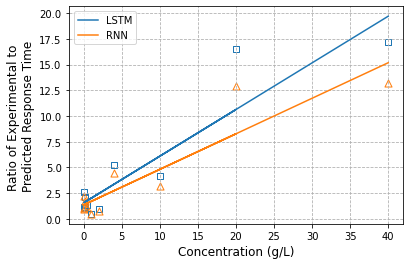

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
markerSize = 50

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None,index_col=0)
time = df_full.iloc[0,:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.index[1:]
df_data = df_full.iloc[1:,:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)


concentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
fig, ax = plt.subplots()
MeanPredictionT90LSTM = []
MeanPredictionT90RNN = []
MeanPredictionT90GRU = []
MeanExperimentalT90 = []
RatioT90LSTM = []
RatioT90RNN = []
RatioT90GRU = []

for concentration in concentrations:
    
    if TestOrTrainDataset == 'train':
        X_train = df_norm_train.loc[concentration,:SequenceLength].values
        y_train = df_norm_train.loc[concentration,SequenceLength-1].values
        X_train = np.expand_dims(X_train, 2)
        y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
        y_train = np.expand_dims(y_train, 2)
        X = X_train
        y = y_train
    
    elif TestOrTrainDataset == 'test':
        X_test = df_norm_test.loc[concentration,:SequenceLength].values
        y_test = df_norm_test.loc[concentration,SequenceLength-1].values
        X_test = np.expand_dims(X_test, 2)
        y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
        y_test = np.expand_dims(y_test, 2)
        X = X_test
        y = y_test
    
    NumGoodModels = 0
    MeanLSTM = tf.zeros([len(X),SequenceLength])
    MeanRNN = tf.zeros([len(X),SequenceLength])
    MeanGRU = tf.zeros([len(X),SequenceLength])
    PredictionLSTM = tf.zeros([len(X),SequenceLength])
    PredictionRNN = tf.zeros([len(X),SequenceLength])
    PredictionGRU = tf.zeros([len(X),SequenceLength])
    
    for i in range(NumEnsemble):
        checkpoint_filepathLSTM = "../Models/EnsembleModel" + str(i+1)
        bestModelLSTM = keras.models.load_model(checkpoint_filepathLSTM, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        checkpoint_filepathRNN = "../Models/AlternativeModels/RNN/EnsembleModel" + str(i+1)
        bestModelRNN = keras.models.load_model(checkpoint_filepathRNN, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

        checkpoint_filepathGRU = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
        bestModelGRU = keras.models.load_model(checkpoint_filepathGRU, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        
        lossLSTM = bestModelLSTM.evaluate(X, y, batch_size=batch_size)
        lossRNN = bestModelRNN.evaluate(X, y, batch_size=batch_size)
        lossGRU = bestModelGRU.evaluate(X, y, batch_size=batch_size)
        
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        PredictionLSTM = bestModelLSTM.predict(X)
        PredictionRNN = bestModelRNN.predict(X)
        PredictionGRU = bestModelGRU.predict(X)
        
        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])

        MeanLSTM += PredictionLSTM[:,:,0]
        MeanRNN += PredictionRNN[:,:,0]
        MeanGRU += PredictionGRU[:,:,0]
        NumGoodModels += 1

    MeanLSTM /= NumGoodModels
    MeanRNN /= NumGoodModels
    MeanGRU /= NumGoodModels
    PredictionT90LSTM = []
    PredictionT90RNN = []
    PredictionT90GRU = []
    ExperimentalT90 = []
    
    for meanlstm,x,meanrnn,meangru in zip(MeanLSTM,X,MeanRNN,MeanGRU):

        # Boolean 1D array of when the model prediction or experimental response was within 10% of
        # the final equilibrium experimental response
        PredictionEquilibriumSeriesLSTM = np.array((meanlstm > x[-1]*(1-t90Window))&(meanlstm < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesRNN = np.array((meanrnn > x[-1]*(1-t90Window))&(meanrnn < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesGRU = np.array((meangru > x[-1]*(1-t90Window))&(meangru < x[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
        
        # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
        PredictionT90LSTM.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesLSTM)))
        PredictionT90RNN.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesRNN)))
        PredictionT90GRU.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesGRU)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))

        time = np.array(time, dtype=float)
    
    meanpredictiont90lstm = np.mean(PredictionT90LSTM)
    meanpredictiont90rnn = np.mean(PredictionT90RNN)
    meanpredictiont90gru = np.mean(PredictionT90GRU)
    meanexperimentalt90 = np.mean(ExperimentalT90)
    ratiot90lstm = meanexperimentalt90/meanpredictiont90lstm
    ratiot90rnn = meanexperimentalt90/meanpredictiont90rnn
    ratiot90gru = meanexperimentalt90/meanpredictiont90gru
    
    MeanPredictionT90LSTM.append(meanpredictiont90lstm)
    MeanPredictionT90RNN.append(meanpredictiont90rnn)
    MeanPredictionT90GRU.append(meanpredictiont90gru)
    MeanExperimentalT90.append(meanexperimentalt90)
    
    RatioT90LSTM.append(ratiot90lstm)
    RatioT90RNN.append(ratiot90rnn)
    RatioT90GRU.append(ratiot90gru)
    
    Concentration = float(concentration)
    ax.scatter(Concentration,ratiot90lstm, facecolor=(0,0,0,0), edgecolor="tab:blue", marker='s', s=markerSize-20)
    ax.scatter(Concentration,ratiot90rnn, facecolor=(0,0,0,0), edgecolor="tab:orange", marker='^', s=markerSize)
#     ax.scatter(Concentration,ratiot90gru, facecolor=(0,0,0,0), edgecolor="g", marker='o', s=markerSize)
 
Concentrations = [float(i) for i in concentrations]

LinearFit = LinearRegression()
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90LSTM,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="LSTM",color="tab:blue")
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90RNN,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="RNN",color="tab:orange")
# LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90GRU,(-1, 1)))
# ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="GRU",color="tab:grreen")

# plt.semilogx(Concentrations,RatioT90)    
# plt.show()
ax.set_ylabel('Ratio of Experimental to \nPredicted Response Time', fontsize = 12)
ax.set_xlabel('Concentration (g/L)', fontsize = 12)

plt.legend()
plt.grid(which='major',linestyle='--')

plt.savefig("../Figures/t90ReductionLSTMvsRNNvsConcentrationMean.tif", dpi=200, bbox_inches='tight')
plt.show()

## LSTM and RNN Performance vs Concentration Evaluation Median

1/1 [==============================] - 0s 232ms/step


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 247ms/step


1/1 [==============================] - 0s 168ms/step


1/1 [==============================] - 0s 238ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 197ms/step - loss: -3.5280


1/1 [==============================] - 0s 248ms/step


1/1 [==============================] - 0s 249ms/step


1/1 [==============================] - 0s 239ms/step


1/1 [==============================] - 0s 196ms/step - loss: -3.6582


1/1 [==============================] - 0s 237ms/step


1/1 [==============================] - 0s 236ms/step


1/1 [==============================] - 0s 252ms/step


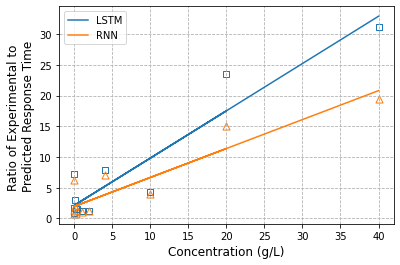

In [3]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## input parameters

# number of models in the ensemble
NumEnsemble = 10
# length of time series
SequenceLength = 250
batch_size = 32
NumEpochs = 2000
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
markerSize = 50

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None,index_col=0)
time = df_full.iloc[0,:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.index[1:]
df_data = df_full.iloc[1:,:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)



concentrations = ["2","0.002","0.02","0.2","0.4","1","4","10","20","0.1","0.04","40"]
fig, ax = plt.subplots()
MedianPredictionT90LSTM = []
MedianPredictionT90RNN = []
MedianPredictionT90GRU = []
MedianExperimentalT90 = []
RatioT90LSTM = []
RatioT90RNN = []
RatioT90GRU = []

for concentration in concentrations:

    
    if TestOrTrainDataset == 'train':
        X_train = df_norm_train.loc[concentration,:SequenceLength].values
        y_train = df_norm_train.loc[concentration,SequenceLength-1].values
        X_train = np.expand_dims(X_train, 2)
        y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
        y_train = np.expand_dims(y_train, 2)
        X = X_train
        y = y_train
    
    elif TestOrTrainDataset == 'test':
        X_test = df_norm_test.loc[concentration,:SequenceLength].values
        y_test = df_norm_test.loc[concentration,SequenceLength-1].values
        X_test = np.expand_dims(X_test, 2)
        y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
        y_test = np.expand_dims(y_test, 2)
        X = X_test
        y = y_test
    
    NumGoodModels = 0
    MeanLSTM = tf.zeros([len(X),SequenceLength])
    MeanRNN = tf.zeros([len(X),SequenceLength])
    MeanGRU = tf.zeros([len(X),SequenceLength])
    PredictionLSTM = tf.zeros([len(X),SequenceLength])
    PredictionRNN = tf.zeros([len(X),SequenceLength])
    PredictionGRU = tf.zeros([len(X),SequenceLength])
    
    for i in range(NumEnsemble):
        checkpoint_filepathLSTM = "../Models/EnsembleModel" + str(i+1)
        bestModelLSTM = keras.models.load_model(checkpoint_filepathLSTM, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        checkpoint_filepathRNN = "../Models/AlternativeModels/RNN/EnsembleModel" + str(i+1)
        bestModelRNN = keras.models.load_model(checkpoint_filepathRNN, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})

        checkpoint_filepathGRU = "../Models/AlternativeModels/GRU/EnsembleModel" + str(i+1)
        bestModelGRU = keras.models.load_model(checkpoint_filepathGRU, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
        
        
        lossLSTM = bestModelLSTM.evaluate(X, y, batch_size=batch_size)
        lossRNN = bestModelRNN.evaluate(X, y, batch_size=batch_size)
        lossGRU = bestModelGRU.evaluate(X, y, batch_size=batch_size)
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        PredictionLSTM = bestModelLSTM.predict(X)
        PredictionRNN = bestModelRNN.predict(X)
        PredictionGRU = bestModelGRU.predict(X)
        
        # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
        # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])

        MeanLSTM += PredictionLSTM[:,:,0]
        MeanRNN += PredictionRNN[:,:,0]
        MeanGRU += PredictionGRU[:,:,0]
        NumGoodModels += 1

    MeanLSTM /= NumGoodModels
    MeanRNN /= NumGoodModels
    MeanGRU /= NumGoodModels
    PredictionT90LSTM = []
    PredictionT90RNN = []
    PredictionT90GRU = []
    ExperimentalT90 = []
    
    for meanlstm,x,meanrnn,meangru in zip(MeanLSTM,X,MeanRNN,MeanGRU):

        # Boolean 1D array of when the model prediction or experimental response was within 10% of
        # the final equilibrium experimental response
        PredictionEquilibriumSeriesLSTM = np.array((meanlstm > x[-1]*(1-t90Window))&(meanlstm < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesRNN = np.array((meanrnn > x[-1]*(1-t90Window))&(meanrnn < x[-1]*(1+t90Window)))
        PredictionEquilibriumSeriesGRU = np.array((meangru > x[-1]*(1-t90Window))&(meangru < x[-1]*(1+t90Window)))
        ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))
        
        # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
        PredictionT90LSTM.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesLSTM)))
        PredictionT90RNN.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesRNN)))
        PredictionT90GRU.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeriesGRU)))
        ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))

        time = np.array(time, dtype=float)
    
    medianpredictiont90lstm = np.median(PredictionT90LSTM)
    medianpredictiont90rnn = np.median(PredictionT90RNN)
    medianpredictiont90gru = np.median(PredictionT90GRU)
    medianexperimentalt90 = np.median(ExperimentalT90)
    ratiot90lstm = medianexperimentalt90/medianpredictiont90lstm
    ratiot90rnn = medianexperimentalt90/medianpredictiont90rnn
    ratiot90gru = medianexperimentalt90/medianpredictiont90gru
    
    MedianPredictionT90LSTM.append(medianpredictiont90lstm)
    MedianPredictionT90RNN.append(medianpredictiont90rnn)
    MedianPredictionT90GRU.append(medianpredictiont90gru)
    MedianExperimentalT90.append(medianexperimentalt90)
    
    RatioT90LSTM.append(ratiot90lstm)
    RatioT90RNN.append(ratiot90rnn)
    RatioT90GRU.append(ratiot90gru)
    
    Concentration = float(concentration)
    ax.scatter(Concentration,ratiot90lstm, facecolor=(0,0,0,0), edgecolor="tab:blue", marker='s', s=markerSize-20)
    ax.scatter(Concentration,ratiot90rnn, facecolor=(0,0,0,0), edgecolor="tab:orange", marker='^', s=markerSize)
#     ax.scatter(Concentration,ratiot90gru, facecolor=(0,0,0,0), edgecolor="g", marker='o', s=markerSize)
 
Concentrations = [float(i) for i in concentrations]

LinearFit = LinearRegression()
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90LSTM,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="LSTM",color="tab:blue")
LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90RNN,(-1, 1)))
ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="RNN",color="tab:orange")
# LinearFit.fit(np.reshape(Concentrations,(-1, 1)), np.reshape(RatioT90GRU,(-1, 1)))
# ax.plot(Concentrations,LinearFit.predict(np.reshape(Concentrations,(-1, 1))),label="GRU",color="tab:grreen")

ax.set_ylabel('Ratio of Experimental to \nPredicted Response Time', fontsize = 12)
ax.set_xlabel('Concentration (g/L)', fontsize = 12)

plt.legend()
plt.grid(which='major',linestyle='--')

plt.savefig("../Figures/t90ReductionLSTMvsRNNvsConcentrationMedian.tif", dpi=200, bbox_inches='tight')
plt.show()

## Histogram of ratio of experimental to experimental data model predicted t90 times

3/3 [==============================] - 0s 32ms/step
                0
count   78.000000
mean    18.619599
std     26.613287
min      0.135135
25%      1.007753
50%      5.070833
75%     26.250000
max    106.000000


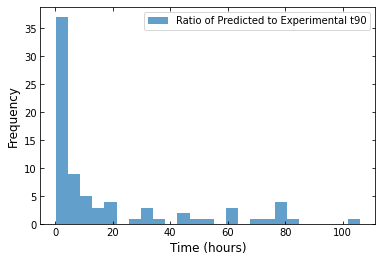

In [7]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 15
# length of time series
SequenceLength = 250
batch_size = 4
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2
NumberOfBins = 25

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
        
Mean /= NumEnsemble

PredictionT90 = []
ExperimentalT90 = []

for mean,x in zip(Mean,X):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]

RatioT90 = np.array(ExperimentalT90)/np.array(PredictionT90)

print(pd.DataFrame(RatioT90).describe())

freq, bins = np.histogram(RatioT90, NumberOfBins)

fig, ax = plt.subplots()
ax.hist(RatioT90, histtype="stepfilled", bins=NumberOfBins, alpha=0.7,label='Ratio of Predicted to Experimental t90')

ax.set_ylabel('Frequency', fontsize = 12)
ax.set_xlabel('Time (hours)', fontsize = 12)

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
ax.legend(loc='upper right')

plt.savefig(".."+"/Figures/RatioExperimentalPredictedt90Histogram.tif", dpi=200, bbox_inches='tight')
plt.show()

## Box and whisker plot of ratio of experimental to experimental data model predicted t90 times

3/3 [==============================] - 0s 31ms/step
                0
count   78.000000
mean    18.619599
std     26.613287
min      0.135135
25%      1.007753
50%      5.070833
75%     26.250000
max    106.000000


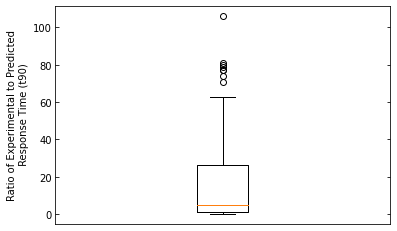

In [5]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 15
# length of time series
SequenceLength = 250
batch_size = 4
TestOrTrainDataset = 'test' #'train' or 'test'
t90Window = 0.1 # t90 is defined as the time until the response settles to within this fraction of the equilibrium response indefinitely
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Prediction = tf.zeros([len(X),SequenceLength])

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)    
    # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
    # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
    # for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
    Prediction = bestModel.predict(X)
    

    # make a prediction for every time series in X dataset individually, remove extraneous dimensions and convert to np.array
    # Prediction = np.squeeze([bestModel.predict(np.expand_dims(X[i,::], 0)) for  i in range(len(X))])
    
    Mean += Prediction[:,:,0]
        
Mean /= NumEnsemble

PredictionT90 = []
ExperimentalT90 = []

for mean,x in zip(Mean,X):
    
    # Boolean 1D array of when the model prediction or experimental response was within 10% of
    # the final equilibrium experimental response
    PredictionEquilibriumSeries = np.array((mean > x[-1]*(1-t90Window))&(mean < x[-1]*(1+t90Window)))
    ExperimentalEquilibriumSeries = np.array((x > x[-1]*(1-t90Window))&(x < x[-1]*(1+t90Window)))

    # finds the latest time point at which the model was outisde the range of final equilirium response +/- 10%
    PredictionT90.append(SequenceLength - np.argmin(np.flip(PredictionEquilibriumSeries)))
    ExperimentalT90.append(SequenceLength - np.argmin(np.flip(ExperimentalEquilibriumSeries)))
    
PredictionT90 = [t90 * time.iloc[-1]/250 for t90 in PredictionT90]
ExperimentalT90 = [t90 * time.iloc[-1]/250 for t90 in ExperimentalT90]

RatioT90 = np.array(ExperimentalT90)/np.array(PredictionT90)

print(pd.DataFrame(RatioT90).describe())

fig, ax = plt.subplots()
ax.boxplot(RatioT90)#,showmeans=False,showextrema=False,showmedians=True,quantiles=[0.25,0.75])

# plt.xlabel("")
plt.ylabel("Ratio of Experimental to Predicted\n Response Time (t90)")
# plt.text(0.55,25,"Mean "+str(RatioT90.mean())+"\nLower Quartile "+str(np.quantile(RatioT90,0.25))+"\nMedian "+str(np.quantile(RatioT90,0.5))+"\nUpper Quartile "+str(np.quantile(RatioT90,0.75)))
ax.tick_params(right=True, top=False, bottom=False, labelbottom=False, labelright=False, labeltop=False)
ax.tick_params(direction="in")
# ax.set_xlim([0.4,1.26])

plt.savefig("../Figures/BoxandWhiskerPlotExperimentalPredictedt90Ratio.tif", dpi=200, bbox_inches='tight')
plt.show()

# Useful plots, but not figures

## Individual plots of all experimental, experimental data model ensemble prediction (mean & variance) and ideal responses

2023-12-02 23:20:20.105909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 23:20:20.110144: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 23:20:20.110320: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 23:20:20.110705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2023-12-02 23:20:23.569591: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


 5/20 [======>.......................] - ETA: 0s - loss: -3.7862

2023-12-02 23:20:24.095530: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


3/3 [==============================] - 0s 27ms/step


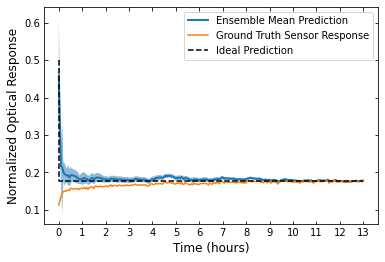

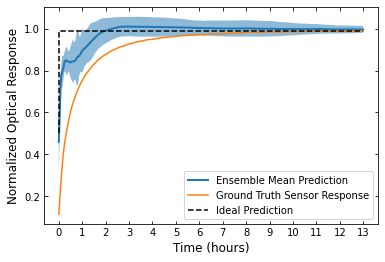

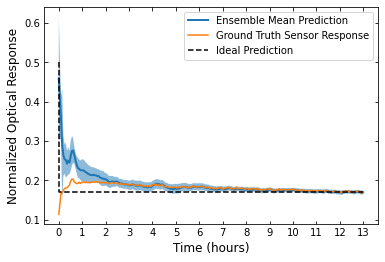

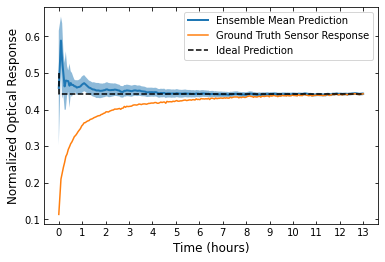

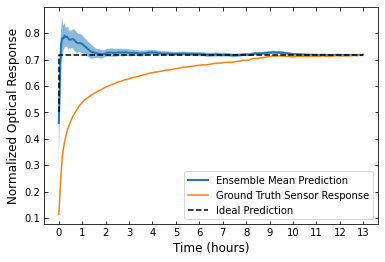

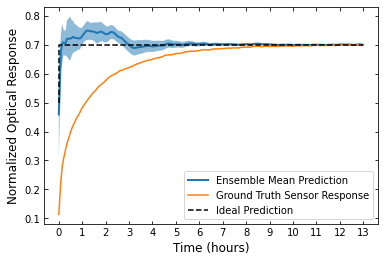

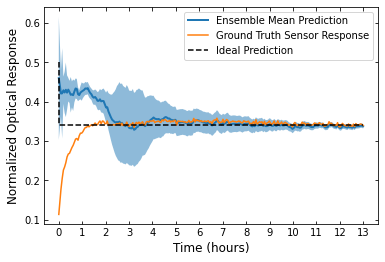

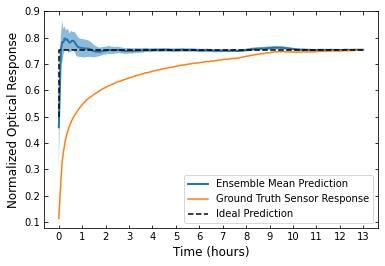

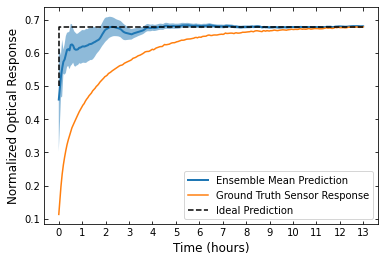

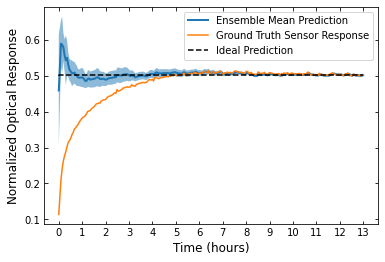

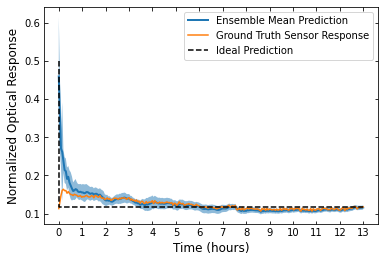

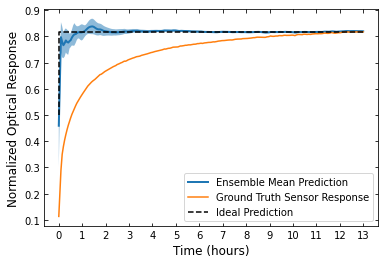

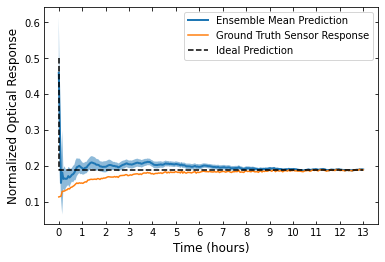

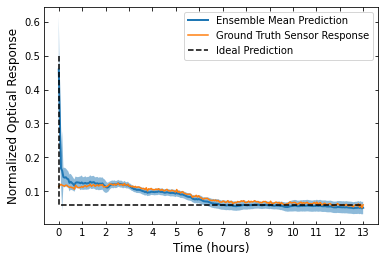

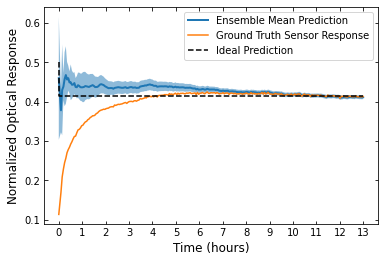

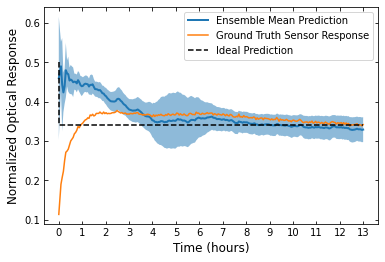

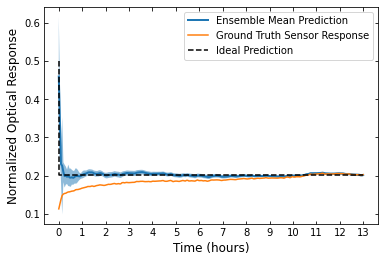

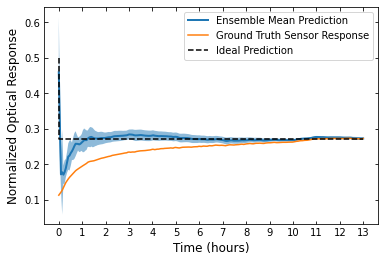

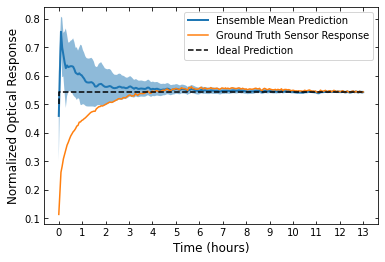

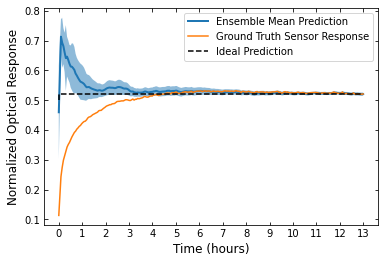

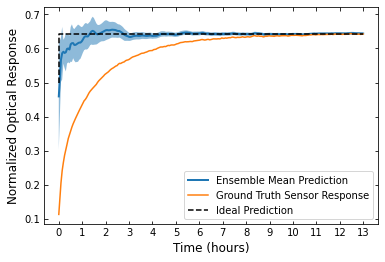

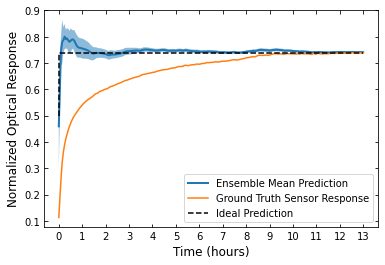

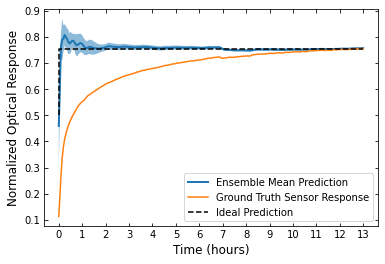

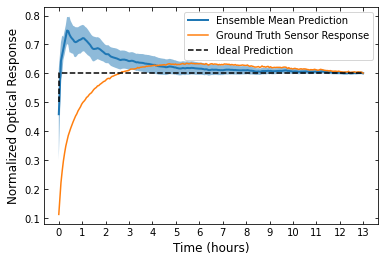

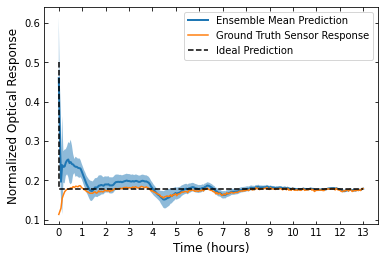

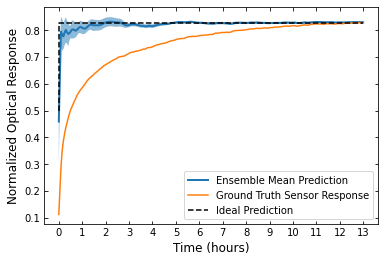

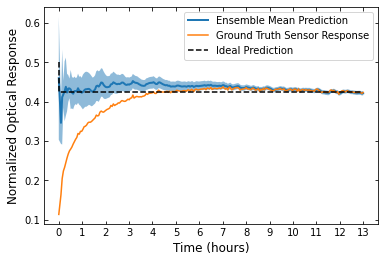

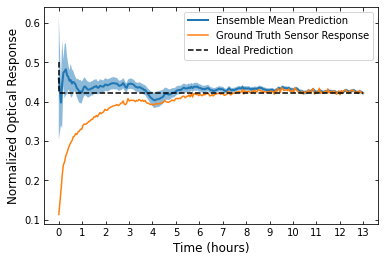

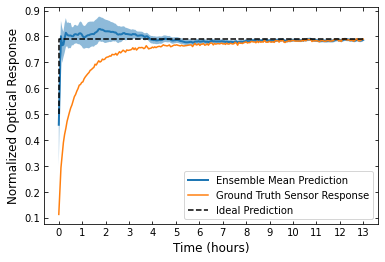

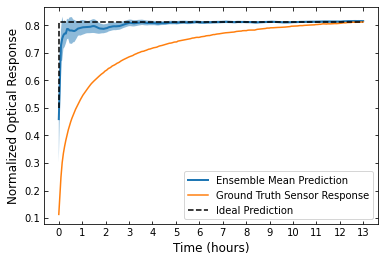

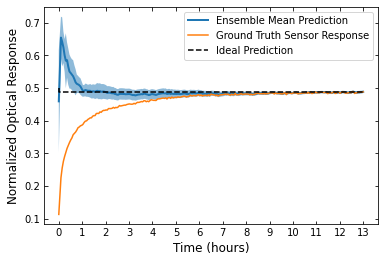

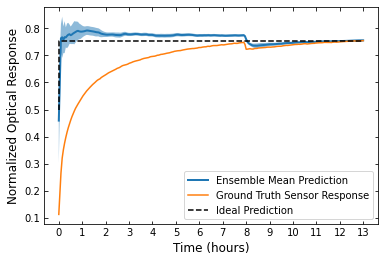

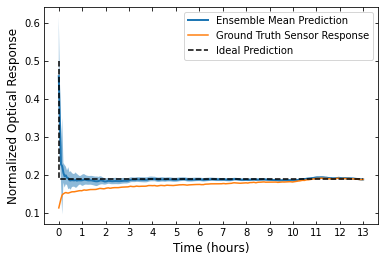

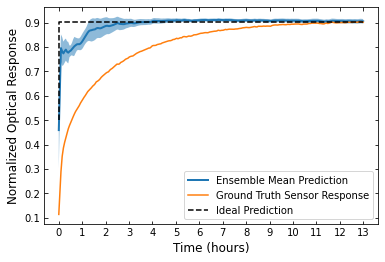

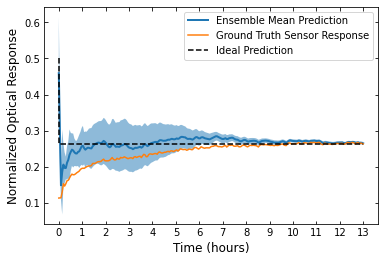

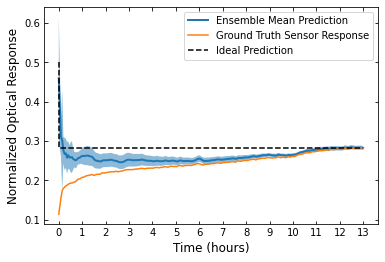

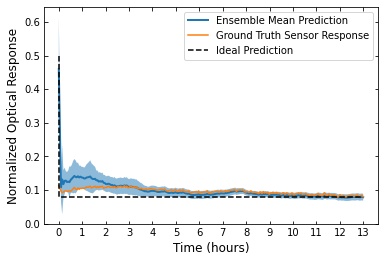

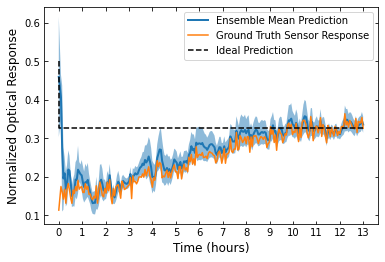

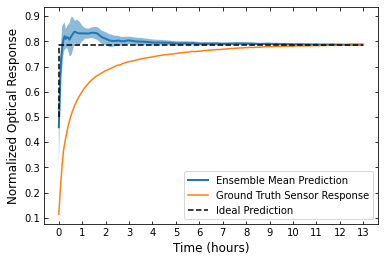

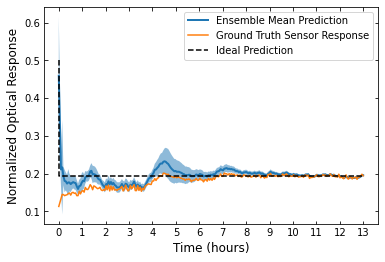

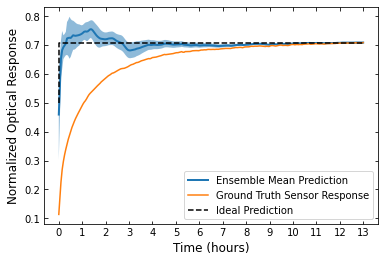

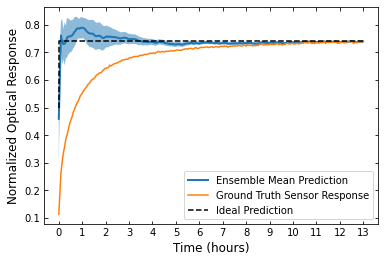

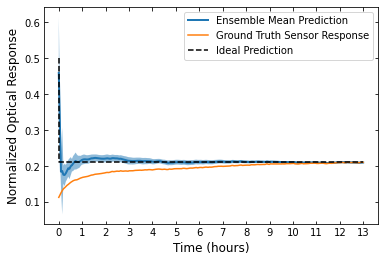

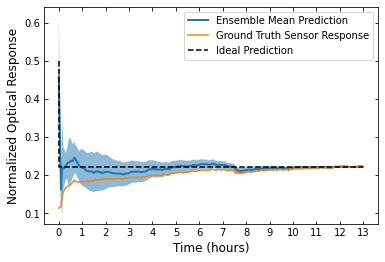

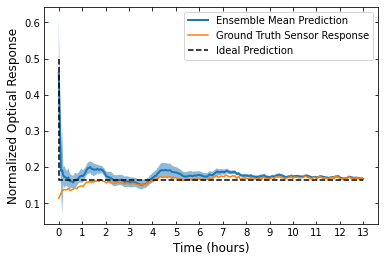

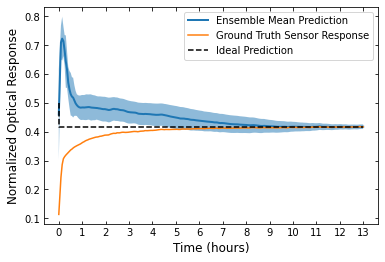

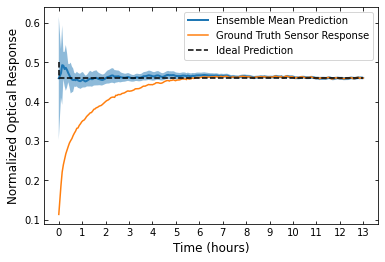

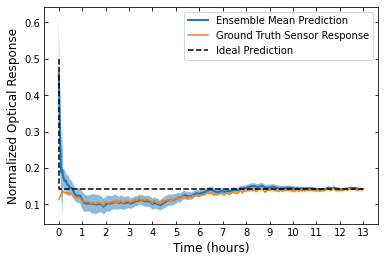

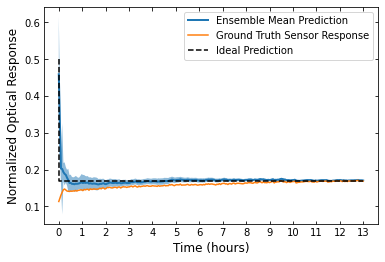

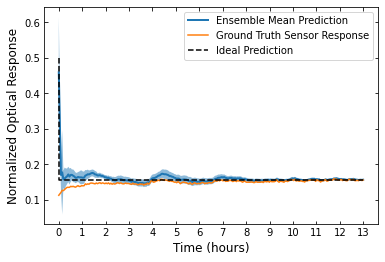

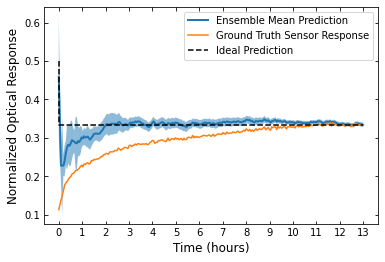

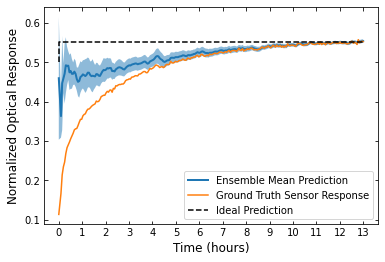

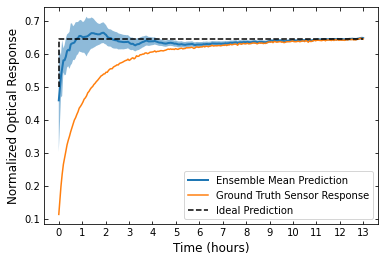

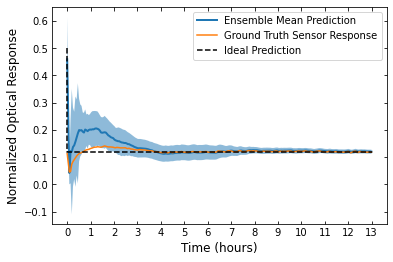

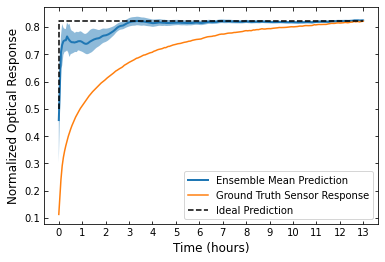

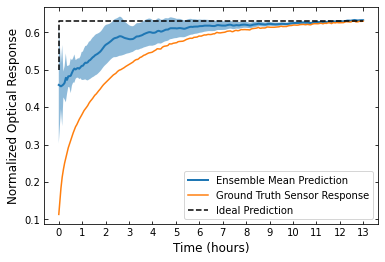

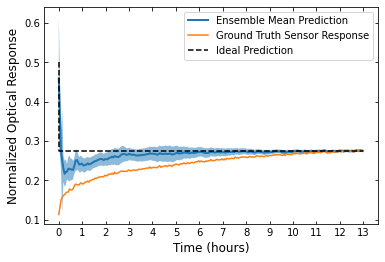

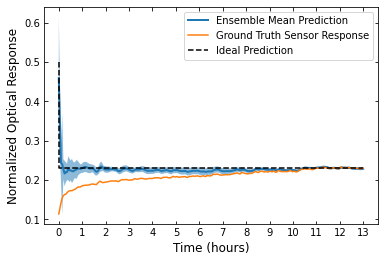

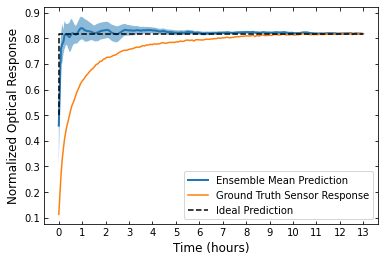

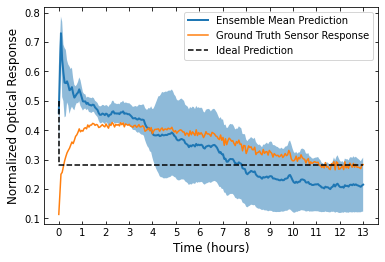

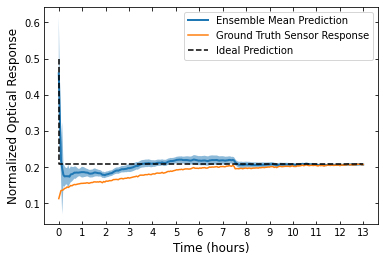

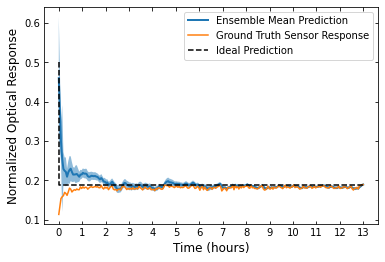

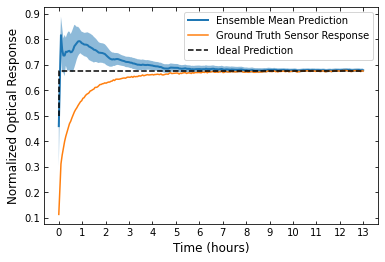

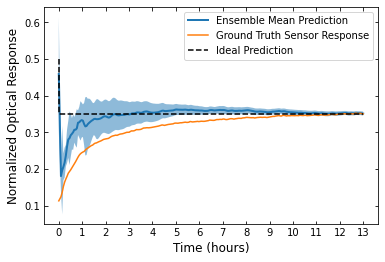

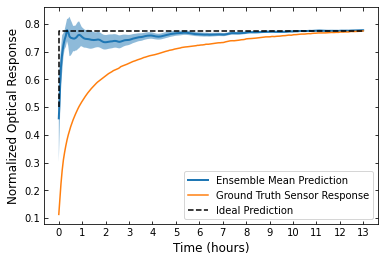

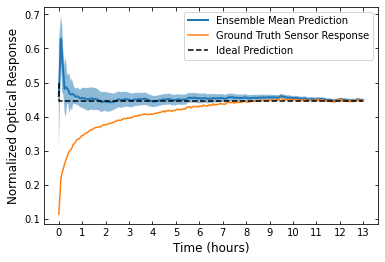

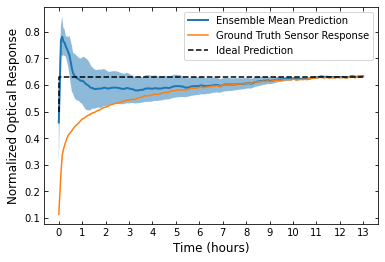

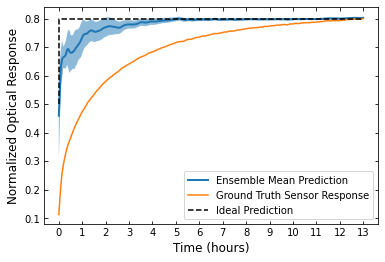

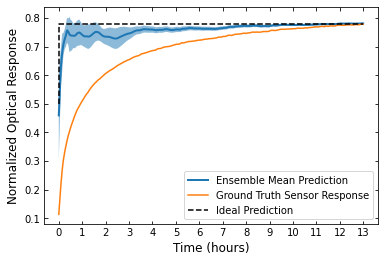

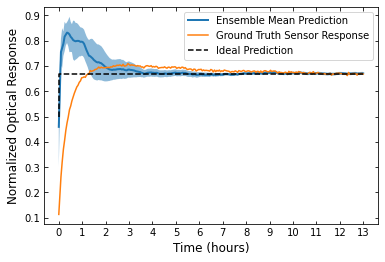

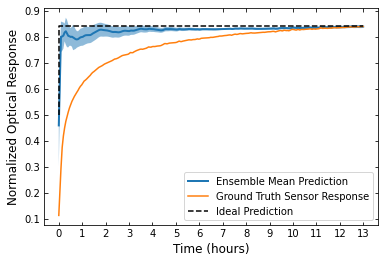

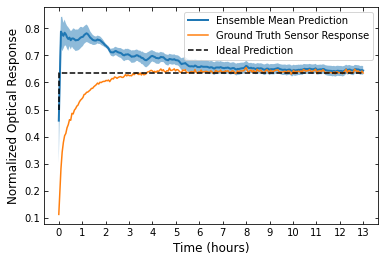

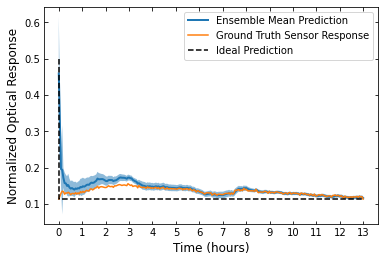

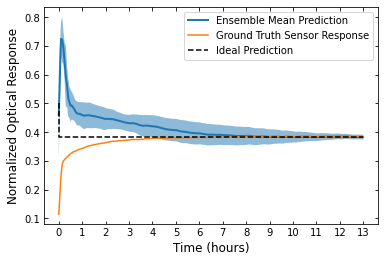

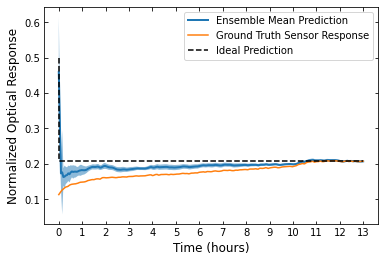

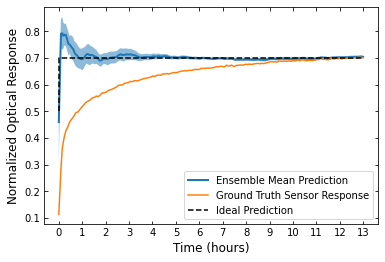

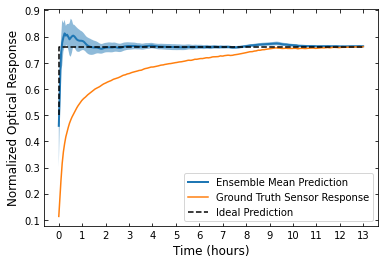

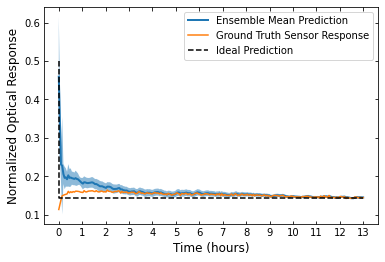

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split

## input parameters

# number of models in the ensemble
NumEnsemble = 15
# length of time series
SequenceLength = 250
batch_size = 4
StdevsFromMean = 2 #1, 2 and 3 standard deviations away from the mean encompasses 68%, 95% and 99.7% of the distribution, respectively 
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

# read experimental data and split into time (s) converted to hours, concentration labels and time series data
df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
idealTime = np.append([0,0], time.iloc[2:,].values)
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

min_value, max_value = df_data.min().min(), df_data.max().max()
# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test
    
Mean = tf.zeros([len(X),SequenceLength])
Variance = tf.zeros([len(X),SequenceLength])

NumGoodModels = 0

for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)
    if(loss<-2):
        # predicts all time series at once, but for some reason has up to a ~5% error compared to calling.predict() on one example
        # perhaps model.predict() is not always deterministic? This is fine for visualisation, but not for real predictions
        #for some reason predicting on X_train[0:6,::] for example does give identical results to predicting any one indivdually..
        prediction = bestModel.predict(X)
        
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
        
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

for mean,variance,x_train in zip(Mean,Variance,X):
    
    Stdev = np.squeeze(variance**0.5)
    
    time = np.array(time, dtype=float)
    idealPrediction = np.ones(len(idealTime))*x_train[-1]
    idealPrediction[0] = 0.5
    
    fig, ax = plt.subplots()

    ax.fill_between(time, (mean+Stdev*StdevsFromMean), (mean-Stdev*StdevsFromMean), alpha=.5, linewidth=0)
    ax.plot(time, mean, linewidth=2, label='Ensemble Mean Prediction')
    plt.plot(time,tf.squeeze(x_train), label="Ground Truth Sensor Response")
    plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')

    ax.set_ylabel('Normalized Optical Response', fontsize = 12)
    ax.set_xlabel('Time (hours)', fontsize = 12)

    ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
    ax.tick_params(direction="in")
    ax.set_xticks(range(14))
    ax.legend()

    plt.show()

## Plot of experimental, individual experimental data model ensemble base learner predictions (including mean) and ideal responses

2023-12-02 23:26:18.465909: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 23:26:18.470568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 23:26:18.470742: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-02 23:26:18.471320: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

2023-12-02 23:26:21.910741: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


3/3 [==============================] - 2s 24ms/step - loss: -2.8173


2023-12-02 23:26:22.469105: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 409ms/step
[0.7033432]
1/1 [==============================] - 0s 383ms/step
[0.69856316]
1/1 [==============================] - 0s 400ms/step
[0.69986224]
1/1 [==============================] - 0s 385ms/step
[0.70103765]
1/1 [==============================] - 0s 380ms/step
[0.7012761]
1/1 [==============================] - 0s 379ms/step
[0.6978081]
1/1 [==============================] - 0s 391ms/step
[0.70027554]
1/1 [==============================] - 0s 398ms/step
[0.7002251]
1/1 [==============================] - 0s 372ms/step
[0.7008594]
1/1 [==============================] - 0s 374ms/step
[0.7017652]


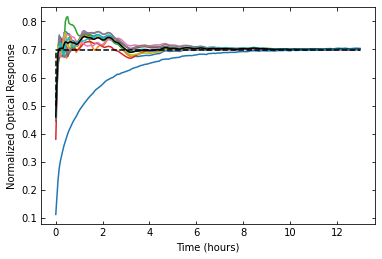

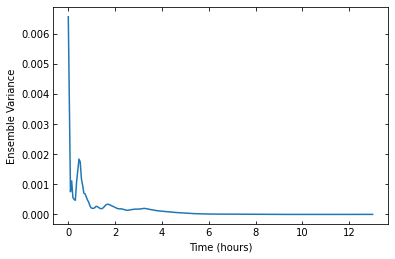

In [2]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from LSTMutils import MeanVarianceLogLikelyhoodLoss
from sklearn.model_selection import train_test_split


NumEnsemble = 15
SequenceLength = 250
batch_size = 4
predict_num = 5
TestOrTrainDataset = 'test' #'train' or 'test'
test_split = 0.2

df_full = pd.read_csv(r"../TrainingData/ExperimentalTrainingSet.csv",sep=',',header=None)
time = df_full.iloc[0,1:]/3600
labels = df_full.iloc[1:,0]
df_data = df_full.iloc[1:,1:]

# split data into stratified train and test sets, size defined by the test_split variable
# the split will always be the same provided the data is in the same order, the same random_state is used,
# and strangely the labels used for stratification are always the same type (str)

df_train, df_test = train_test_split(df_data, test_size=test_split, train_size=1-test_split, random_state=42, shuffle=True, stratify=labels)

# normalise time series data
min_value, max_value = df_train.min().min(), df_train.max().max()
df_norm_train = (df_train - min_value)/(max_value - min_value)
df_norm_test = (df_test - min_value)/(max_value - min_value)

if TestOrTrainDataset == 'train':
    X_train = df_norm_train.iloc[:,:SequenceLength].values
    y_train = df_norm_train.iloc[:,SequenceLength-1].values
    X_train = np.expand_dims(X_train, 2)
    y_train = np.broadcast_to(y_train[:,None], (y_train.shape[0],SequenceLength))
    y_train = np.expand_dims(y_train, 2)
    X = X_train
    y = y_train
elif TestOrTrainDataset == 'test':
    X_test = df_norm_test.iloc[:,:SequenceLength].values
    y_test = df_norm_test.iloc[:,SequenceLength-1].values
    X_test = np.expand_dims(X_test, 2)
    y_test = np.broadcast_to(y_test[:,None], (y_test.shape[0],SequenceLength))
    y_test = np.expand_dims(y_test, 2)
    X = X_test
    y = y_test

Mean = tf.zeros([1,SequenceLength])
Variance = tf.zeros([1,SequenceLength])
X_predict = np.expand_dims(X[predict_num,::], 0)

idealTime = np.append([0,0], time.iloc[2:,].values)
idealPrediction = np.ones(len(idealTime))*X_predict[0,-1,0]
idealPrediction[0] = 0.5

fig, ax = plt.subplots()
NumGoodModels = 0
for i in range(NumEnsemble):
    checkpoint_filepath = "../Models/ExperimentalDataEnsembleModels/ExperimentalDataEnsembleModel" + str(i+1)
    bestModel = keras.models.load_model(checkpoint_filepath, custom_objects={"MeanVarianceLogLikelyhoodLoss": MeanVarianceLogLikelyhoodLoss})
    loss = bestModel.evaluate(X, y, batch_size=batch_size)
    if(loss<-2):
        prediction = bestModel.predict(X_predict)
        plt.plot(time,tf.squeeze(prediction[:,:,0]),label=f"model {NumGoodModels} Prediction")
        print(prediction[:,-1,0])
        Mean += prediction[:,:,0]
        Variance += (prediction[:,:,0])**2 + prediction[:,:,1]**2
        NumGoodModels += 1
Mean /= NumGoodModels
Variance /= NumGoodModels
Variance -= Mean**2

plt.plot(time,tf.squeeze(Mean),label="Mean Prediction",color='k')
plt.plot(time,tf.squeeze(X_predict), label="Ground Truth Sensor Response")
plt.plot(idealTime,idealPrediction, label="Ideal Prediction",color='k',linestyle='--')
plt.xlabel("Time (hours)")
plt.ylabel("Normalized Optical Response")

ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
# plt.legend(loc='right')
plt.show()

fig, ax = plt.subplots()
plt.plot(time,tf.squeeze(Variance), label="Variance")
plt.xlabel("Time (hours)")
plt.ylabel("Ensemble Variance")
ax.tick_params(right=True, top=True, labelright=False, labeltop=False)
ax.tick_params(direction="in")
plt.show()